<a href="https://colab.research.google.com/github/s1m0nS/mapAI-UNet/blob/main/UNet_binary_segmentation_mapAI_small-working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Binary semantic segmentation example using U-Net

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial118_binary_semantic_segmentation_using_unet.ipynb

In [1]:
# Libraries

# Change runtime type in Colab

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # ignore tensorflow warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' # allow GPU memory growth

import glob

import cv2
from PIL import Image

import numpy as np
from matplotlib import pyplot as pltd

from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

import tensorflow as tf
print(tf.test.gpu_device_name())
print('\n')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/device:GPU:0


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1040174837444963034
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14401011712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13336263542530399601
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Unzip dataset --> run only in Colab
import zipfile

# '/content/drive/MyDrive/mapAI_small/mapai_small.zip'

mapai_zip = '/content/drive/MyDrive/mapAI_small/mapai_small.zip'
zip_ref = zipfile.ZipFile(mapai_zip, 'r')
zip_ref.extractall("/tmp") # extracting dataset to tmp folder
zip_ref.close()

# Re-run from here after first run! 

In [3]:
# Configure paths

img_dir = '/tmp/mapai_small/train/images'
mask_dir = '/tmp/mapai_small/train/masks'

In [4]:
SIZE = 500
train_num_images = 510
test_num_images = 100

### Prepare data
https://github.com/HVL-ML/LAB-Net/blob/master/nbs/00a_mapai_prepare_data.ipynb

In [5]:
#!pip install datasets

from datasets import load_dataset


from pathlib import Path
import shutil
import pandas as pd
import datetime

from PIL import Image
import numpy as np, matplotlib.pyplot as plt
import skimage

### Analyze buildings ###
def get_building_percentage(maskfn, plot=False):
    mask = Image.open(maskfn)
    if plot: 
        plt.imshow(mask)
        plt.axis('off')
        plt.show()
    total_area = np.prod(mask.size)
    mask_percentage = (np.sum(mask)/total_area)
    return mask_percentage

def count_buildings(maskfn, plot=False):
    mask = Image.open(maskfn)
    if plot: 
        plt.imshow(mask)
        plt.axis('off')
        plt.show()
    return len(np.unique(skimage.measure.label(np.array(mask))))-1

### TRAIN IMAGES

In [6]:
train_image_names = glob.glob('/tmp/mapai_small/train/images/*.png')
train_image_names.sort()
train_image_names_subset = train_image_names[0:train_num_images]
train_images = [cv2.imread(img, 0) for img in train_image_names_subset]
train_image_dataset = np.array(train_images)
train_image_dataset = np.expand_dims(train_image_dataset, axis = 3)

print(len(train_image_names))

510


### TRAIN MASKS

In [7]:
train_mask_names = glob.glob('/tmp/mapai_small/train/masks/*.png')
train_mask_names.sort()
train_mask_names_subset = train_mask_names[0:train_num_images]
train_masks = [cv2.imread(mask, 0) for mask in train_mask_names_subset]
train_mask_dataset = np.array(train_masks)
train_mask_dataset = np.expand_dims(train_mask_dataset, axis = 3)

print(len(train_mask_names))

510


#### Print properties of train images


In [8]:
print("Image data shape is: ", train_image_dataset.shape)
print("Mask data shape is: ", train_mask_dataset.shape)
print("Max pixel value in image is: ", train_image_dataset.max())
print("Labels in the mask are : ", np.unique(train_mask_dataset))

Image data shape is:  (510, 500, 500, 1)
Mask data shape is:  (510, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [9]:
# Store train images/masks in dictionary amd create dataframe

# mapAI
#train_data = {'image': train['image'], 'lidar': train['lidar'], 'mask': train['mask'], 'is_val':False}
train_data = {'image': train_image_names, 'mask': train_mask_names, 'is_val': False}

# Create dataframe from dictionary
train_df = pd.DataFrame.from_dict(train_data)
train_df.head()

,image,mask,is_val
0,/tmp/mapai_small/train/images/6051_689_0.png,/tmp/mapai_small/train/masks/6051_689_0.png,False
1,/tmp/mapai_small/train/images/6051_689_1.png,/tmp/mapai_small/train/masks/6051_689_1.png,False
2,/tmp/mapai_small/train/images/6051_689_10.png,/tmp/mapai_small/train/masks/6051_689_10.png,False
3,/tmp/mapai_small/train/images/6051_689_11.png,/tmp/mapai_small/train/masks/6051_689_11.png,False
4,/tmp/mapai_small/train/images/6051_689_12.png,/tmp/mapai_small/train/masks/6051_689_12.png,False


#### Calculate building mask percentage

In [10]:
train_df['mask_percentage'] = train_df['mask'].apply(get_building_percentage)
train_df.head()

,image,mask,is_val,mask_percentage
0,/tmp/mapai_small/train/images/6051_689_0.png,/tmp/mapai_small/train/masks/6051_689_0.png,False,20.70600
1,/tmp/mapai_small/train/images/6051_689_1.png,/tmp/mapai_small/train/masks/6051_689_1.png,False,56.71404
2,/tmp/mapai_small/train/images/6051_689_10.png,/tmp/mapai_small/train/masks/6051_689_10.png,False,7.05330
3,/tmp/mapai_small/train/images/6051_689_11.png,/tmp/mapai_small/train/masks/6051_689_11.png,False,44.98200
4,/tmp/mapai_small/train/images/6051_689_12.png,/tmp/mapai_small/train/masks/6051_689_12.png,False,60.09636


### Read test dataset and perform the same steps

### TEST IMAGES

In [11]:
test_image_names = glob.glob('/tmp/mapai_small/test/images/*.png')
test_image_names.sort()
test_image_names_subset = test_image_names[0:test_num_images]
test_images = [cv2.imread(img, 0) for img in test_image_names_subset]
test_image_dataset = np.array(test_images)
test_image_dataset = np.expand_dims(test_image_dataset, axis = 3)

print(len(test_image_names))

100


### TEST MASKS

In [12]:
test_mask_names = glob.glob('/tmp/mapai_small/test/masks/*.png')
test_mask_names.sort()
test_mask_names_subset = test_mask_names[0:test_num_images]
test_masks = [cv2.imread(mask, 0) for mask in test_mask_names_subset]
test_mask_dataset = np.array(test_masks)
test_mask_dataset = np.expand_dims(test_mask_dataset, axis = 3)

print(len(test_mask_names))

100


#### Print properties of test images

In [13]:
print("Image data shape is: ", test_image_dataset.shape)
print("Mask data shape is: ", test_mask_dataset.shape)
print("Max pixel value in image is: ", test_image_dataset.max())
print("Labels in the mask are : ", np.unique(test_mask_dataset))

Image data shape is:  (100, 500, 500, 1)
Mask data shape is:  (100, 500, 500, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


#### Store test images/masks in dictionary and create dataframe

In [14]:
# mapAI
#train_data = {'image': train['image'], 'lidar': train['lidar'], 'mask': train['mask'], 'is_val':False}
test_data = {'image': test_image_names, 'mask': test_mask_names, 'is_val': False}

# Create dataframe from dictionary
test_df = pd.DataFrame.from_dict(test_data)
test_df.head()

,image,mask,is_val
0,/tmp/mapai_small/test/images/6259_564_0.png,/tmp/mapai_small/test/masks/6259_564_0.png,False
1,/tmp/mapai_small/test/images/6259_564_1.png,/tmp/mapai_small/test/masks/6259_564_1.png,False
2,/tmp/mapai_small/test/images/6259_564_10.png,/tmp/mapai_small/test/masks/6259_564_10.png,False
3,/tmp/mapai_small/test/images/6259_564_11.png,/tmp/mapai_small/test/masks/6259_564_11.png,False
4,/tmp/mapai_small/test/images/6259_564_12.png,/tmp/mapai_small/test/masks/6259_564_12.png,False


#### Calculate building percentage for test

In [15]:
test_df['mask_percentage'] = test_df['mask'].apply(get_building_percentage)
test_df.head()

,image,mask,is_val,mask_percentage
0,/tmp/mapai_small/test/images/6259_564_0.png,/tmp/mapai_small/test/masks/6259_564_0.png,False,47.00874
1,/tmp/mapai_small/test/images/6259_564_1.png,/tmp/mapai_small/test/masks/6259_564_1.png,False,32.41050
2,/tmp/mapai_small/test/images/6259_564_10.png,/tmp/mapai_small/test/masks/6259_564_10.png,False,56.67222
3,/tmp/mapai_small/test/images/6259_564_11.png,/tmp/mapai_small/test/masks/6259_564_11.png,False,41.94444
4,/tmp/mapai_small/test/images/6259_564_12.png,/tmp/mapai_small/test/masks/6259_564_12.png,False,43.62846


#### Concatenate test and train dataframes into one

In [16]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [17]:
# add a new column make it False
df['is_building'] = False

# if mask_percentage > 0 then building = True
df.loc[df['mask_percentage'] > 0, 'is_building'] = True

print(len(df))

610


#### How many buildings do we have all together?

In [18]:
# How many buildings do we all together?
print("Training set size: ", train_df.shape[0])
print("Test set size: ", test_df.shape[0])
print()

# Calculate percentage of buildings
total = train_df.shape[0] + test_df.shape[0]
perc_buildings = round((df.is_building.value_counts()[0]/total) * 100, 2)
perc_other = round((df.is_building.value_counts()[1]/total) * 100, 2)

print("Buildings: ", perc_buildings, "%")
print("Other: ", perc_other, "%")

# from df
df.is_building.value_counts()

Training set size:  510
Test set size:  100

Buildings:  26.07 %
Other:  73.93 %


True     451
False    159
Name: is_building, dtype: int64

#### Save to CSV

In [19]:
# Save to MyDrive/MapAI
df.to_csv(f"/content/drive/MyDrive/MapAI/train_test_original-{datetime.date.today()}.csv", index=False)

## Inspect data


In [20]:
# Read back saved csv

csv_path = "/content/drive/MyDrive/MapAI/train_test_original-2023-02-09.csv"

df = pd.read_csv(csv_path)

In [21]:
from pathlib import Path
from PIL import Image
import numpy as np, pandas as  pd, matplotlib.pyplot as plt


#### Plots ####

def plot_image_and_masks_from_df(imgidx, df, figsize=6, with_segm=True):
    imgfn = str(df.iloc[imgidx]['image'])
    print(imgfn)
    if with_segm:
        maskfn = df.iloc[imgidx]['mask']
        print(maskfn)
    f, ax = plt.subplots(figsize=(figsize,figsize))
    img = Image.open(imgfn)
    ax.imshow(img)
    if with_segm:
        mask = Image.open(maskfn)
        ax.imshow(mask, alpha=0.3)
    imgid = imgfn.split("/")[-1].split(".")[0]
    imgsz = img.size
    ax.set_title(f'{imgid}, {str(imgsz)}')
    ax.set_axis_off()
    return ax


def plot_image_lidar_and_masks_from_df(imgidx, df, figsize=6, with_segm=True):
    imgfn = str(df.iloc[imgidx]['image'])
    lidarfn = str(df.iloc[imgidx]['lidar'])
    if with_segm:
        maskfn = df.iloc[imgidx]['mask']
    f, ax = plt.subplots(1,2, figsize=(figsize,figsize))
    img = Image.open(imgfn)
    lidar = np.array(Image.open(lidarfn))
    ax[0].imshow(img)
    ax[1].imshow(img)
    if with_segm:
        mask = Image.open(maskfn)
        ax[0].imshow(mask, alpha=0.3)
        ax[1].imshow(lidar, alpha=0.3)
    imgid = imgfn.split("/")[-1].split(".")[0]
    imgsz = img.size
    ax[0].set_title(f'{imgid}, {str(imgsz)}')
    ax[0].set_axis_off()
    return ax

from ipywidgets import interact, interactive, IntSlider, Select, RadioButtons, fixed, BoundedIntText


### Code for interactive plot
interactive_plot = interactive(plot_image_and_masks_from_df, df=fixed(df),
                               imgidx = BoundedIntText(min=0, max=len(df)-1, step=1, value=0),
                               figsize = BoundedIntText(min=4, max=12, step=1, value=6),
                               with_segm= RadioButtons(options=[True,False], value=True, 
                                                      description="With segmentation"))

output = interactive_plot.children[-1]

In [22]:
### START INTERACTIVE PLOTTING ###
interactive_plot

# image indexes are messed up --> SOLVED --> Forgot to add after glob.glob()
# IMAGES -> index 0 --> 6084_552_87.png --> incorrect middle picture in folder
# MASKS -> index 0 --> 6051_689_0.png --> correct first picture in folder

interactive(children=(BoundedIntText(value=0, description='imgidx', max=609), BoundedIntText(value=6, descript…

In [23]:
### I wil  also need to create a validation set!

#### Normalize images
Getting OOM errors, maybe need to find a better way to normalize images.

In [24]:
# IMAGES
# Solution: https://stackoverflow.com/questions/62977311/how-can-i-stop-my-colab-notebook-from-crashing-while-normalising-my-images
# float16 or float32? Find answer

# IMAGES
train_image_dataset = (train_image_dataset / 255.0).astype(np.float16)  #Can also normalize or scale using MinMax scaler

# Do we need to normalize test images?
test_image_dataset = (test_image_dataset / 255.0).astype(np.float16)

# MASKS --> Do not normalize masks, just rescale to 0 to 1.
train_mask_dataset = (train_mask_dataset / 255.0).astype(np.float16)   #PIxel values will be 0 or 1

test_mask_dataset = (test_mask_dataset / 255.0).astype(np.float16)


In [25]:
print(len(train_image_dataset), len(train_mask_dataset))
print(len(test_image_dataset), len(test_mask_dataset))

510 510
100 100


### Initialize train / test

In [26]:
X_train, y_train = (train_image_dataset, train_mask_dataset)
X_test, y_test = (test_image_dataset, test_mask_dataset)

#### Randomly view some images from train and test sample

In [ ]:
## View some images from test

### Resize images to approptiate shape for UNet

In [27]:
def resize(image, mask):
    input_image = tf.image.resize(image, (480, 480), method='bicubic')
    input_mask = tf.image.resize(mask, (480, 480), method='bicubic')
    return input_image, input_mask

X_train, y_train = resize(X_train, y_train)
X_test, y_test = resize(X_test, y_test)

### U-Net


In [28]:
# Building Unet by dividing encoder and decoder into blocks

# Add weight regularizer 
# Having more layers does not help sometimes
# Try to decrease the complexity of the model and see the results
# You can start with a more complicated model and add some regularization

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x) #halfes the resoltuion
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    # Decrease the number of filters

    s1, p1 = encoder_block(inputs, 60)
    s2, p2 = encoder_block(p1, 120)
    s3, p3 = encoder_block(p2, 240)
    s4, p4 = encoder_block(p3, 480)

    b1 = conv_block(p4, 960) #Bridge

    d1 = decoder_block(b1, s4, 480)
    d2 = decoder_block(d1, s3, 240)
    d3 = decoder_block(d2, s2, 120)
    d4 = decoder_block(d3, s1, 60)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [29]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(480, 480, 1)


In [30]:
# Build the model
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 480, 480, 60  600         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 480, 480, 60  240        ['conv2d[0][0]']                 
 alization)                     )                                                     

### Train model or at least try
https://www.youtube.com/watch?v=7j0yL8A-k4E

In [31]:
# NEED TO CREATE A VALIDATION SET

history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs= 100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# System RAM: 7.0/12.7
# GPU RAM: 11.9/15

Epoch 1/100
128/128 [==============================] - 151s 1s/step - loss: 0.3878 - accuracy: 0.8376 - val_loss: 2.0534 - val_accuracy: 0.6625
Epoch 2/100
128/128 [==============================] - 120s 938ms/step - loss: 0.2971 - accuracy: 0.8560 - val_loss: 4.7125 - val_accuracy: 0.0865
Epoch 3/100
128/128 [==============================] - 117s 911ms/step - loss: 0.2928 - accuracy: 0.8581 - val_loss: 1.9914 - val_accuracy: 0.2426
Epoch 4/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2695 - accuracy: 0.8609 - val_loss: 1.9286 - val_accuracy: 0.4643
Epoch 5/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2651 - accuracy: 0.8608 - val_loss: 1.9227 - val_accuracy: 0.3358
Epoch 6/100
128/128 [==============================] - 117s 912ms/step - loss: 0.2563 - accuracy: 0.8604 - val_loss: 1.6415 - val_accuracy: 0.2010
Epoch 7/100
128/128 [==============================] - 120s 940ms/step - loss: 0.2483 - accuracy: 0.8657 - val_loss: 0.30

In [ ]:
'''
Epoch 1/5
128/128 [==============================] - 156s 1s/step - loss: 0.0495 - accuracy: 0.8508 - val_loss: 0.5064 - val_accuracy: 0.8282
Epoch 2/5
128/128 [==============================] - 119s 933ms/step - loss: 0.0085 - accuracy: 0.8541 - val_loss: 0.8748 - val_accuracy: 0.8282
Epoch 3/5
128/128 [==============================] - 116s 909ms/step - loss: 0.0040 - accuracy: 0.8541 - val_loss: 2.9965 - val_accuracy: 0.8282
Epoch 4/5
128/128 [==============================] - 120s 934ms/step - loss: 0.0023 - accuracy: 0.8541 - val_loss: 13.8548 - val_accuracy: 0.8282
Epoch 5/5
128/128 [==============================] - 116s 907ms/step - loss: 0.0015 - accuracy: 0.8541 - val_loss: 54.2901 - val_accuracy: 0.8282
'''

In [ ]:
'''
Epoch 1/100
128/128 [==============================] - 151s 1s/step - loss: 0.3878 - accuracy: 0.8376 - val_loss: 2.0534 - val_accuracy: 0.6625
Epoch 2/100
128/128 [==============================] - 120s 938ms/step - loss: 0.2971 - accuracy: 0.8560 - val_loss: 4.7125 - val_accuracy: 0.0865
Epoch 3/100
128/128 [==============================] - 117s 911ms/step - loss: 0.2928 - accuracy: 0.8581 - val_loss: 1.9914 - val_accuracy: 0.2426
Epoch 4/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2695 - accuracy: 0.8609 - val_loss: 1.9286 - val_accuracy: 0.4643
Epoch 5/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2651 - accuracy: 0.8608 - val_loss: 1.9227 - val_accuracy: 0.3358
Epoch 6/100
128/128 [==============================] - 117s 912ms/step - loss: 0.2563 - accuracy: 0.8604 - val_loss: 1.6415 - val_accuracy: 0.2010
Epoch 7/100
128/128 [==============================] - 120s 940ms/step - loss: 0.2483 - accuracy: 0.8657 - val_loss: 0.3011 - val_accuracy: 0.8422
Epoch 8/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2567 - accuracy: 0.8535 - val_loss: 0.6640 - val_accuracy: 0.5724
Epoch 9/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2427 - accuracy: 0.8670 - val_loss: 0.5544 - val_accuracy: 0.6176
Epoch 10/100
128/128 [==============================] - 117s 912ms/step - loss: 0.2458 - accuracy: 0.8656 - val_loss: 0.6131 - val_accuracy: 0.8309
Epoch 11/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2484 - accuracy: 0.8610 - val_loss: 0.2946 - val_accuracy: 0.8199
Epoch 12/100
128/128 [==============================] - 117s 913ms/step - loss: 0.2460 - accuracy: 0.8661 - val_loss: 0.3595 - val_accuracy: 0.8470
Epoch 13/100
128/128 [==============================] - 120s 939ms/step - loss: 0.2345 - accuracy: 0.8713 - val_loss: 0.2959 - val_accuracy: 0.8510
Epoch 14/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2340 - accuracy: 0.8681 - val_loss: 1.4632 - val_accuracy: 0.5260
Epoch 15/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2235 - accuracy: 0.8732 - val_loss: 0.2869 - val_accuracy: 0.8295
Epoch 16/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2286 - accuracy: 0.8722 - val_loss: 0.4677 - val_accuracy: 0.6921
Epoch 17/100
128/128 [==============================] - 120s 938ms/step - loss: 0.2280 - accuracy: 0.8722 - val_loss: 2.7268 - val_accuracy: 0.2859
Epoch 18/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2303 - accuracy: 0.8722 - val_loss: 0.3929 - val_accuracy: 0.7442
Epoch 19/100
128/128 [==============================] - 117s 913ms/step - loss: 0.2206 - accuracy: 0.8763 - val_loss: 0.3704 - val_accuracy: 0.7661
Epoch 20/100
128/128 [==============================] - 117s 913ms/step - loss: 0.2142 - accuracy: 0.8775 - val_loss: 1.4066 - val_accuracy: 0.4847
Epoch 21/100
128/128 [==============================] - 120s 937ms/step - loss: 0.2119 - accuracy: 0.8800 - val_loss: 0.2766 - val_accuracy: 0.8432
Epoch 22/100
128/128 [==============================] - 117s 913ms/step - loss: 0.2034 - accuracy: 0.8808 - val_loss: 0.3275 - val_accuracy: 0.8542
Epoch 23/100
128/128 [==============================] - 120s 938ms/step - loss: 0.1959 - accuracy: 0.8831 - val_loss: 0.3377 - val_accuracy: 0.7849
Epoch 24/100
128/128 [==============================] - 120s 938ms/step - loss: 0.1946 - accuracy: 0.8834 - val_loss: 0.3278 - val_accuracy: 0.8485
Epoch 25/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1865 - accuracy: 0.8848 - val_loss: 0.3092 - val_accuracy: 0.8031
Epoch 26/100
128/128 [==============================] - 117s 911ms/step - loss: 0.1843 - accuracy: 0.8846 - val_loss: 0.2934 - val_accuracy: 0.8446
Epoch 27/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1792 - accuracy: 0.8861 - val_loss: 0.4278 - val_accuracy: 0.8371
Epoch 28/100
128/128 [==============================] - 117s 912ms/step - loss: 0.1731 - accuracy: 0.8881 - val_loss: 0.2894 - val_accuracy: 0.8515
Epoch 29/100
128/128 [==============================] - 117s 912ms/step - loss: 0.1697 - accuracy: 0.8884 - val_loss: 0.2687 - val_accuracy: 0.8578
Epoch 30/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1627 - accuracy: 0.8903 - val_loss: 0.2691 - val_accuracy: 0.8594
Epoch 31/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1531 - accuracy: 0.8925 - val_loss: 0.2824 - val_accuracy: 0.8550
Epoch 32/100
128/128 [==============================] - 117s 911ms/step - loss: 0.1410 - accuracy: 0.8957 - val_loss: 0.2640 - val_accuracy: 0.8600
Epoch 33/100
128/128 [==============================] - 117s 912ms/step - loss: 0.1372 - accuracy: 0.8968 - val_loss: 0.2925 - val_accuracy: 0.8536
Epoch 34/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1270 - accuracy: 0.8996 - val_loss: 0.2963 - val_accuracy: 0.8402
Epoch 35/100
128/128 [==============================] - 117s 912ms/step - loss: 0.1208 - accuracy: 0.9014 - val_loss: 0.2916 - val_accuracy: 0.8608
Epoch 36/100
128/128 [==============================] - 117s 913ms/step - loss: 0.1104 - accuracy: 0.9042 - val_loss: 0.2548 - val_accuracy: 0.8603
Epoch 37/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1142 - accuracy: 0.9029 - val_loss: 0.2877 - val_accuracy: 0.8611
Epoch 38/100
128/128 [==============================] - 120s 936ms/step - loss: 0.1402 - accuracy: 0.8963 - val_loss: 1.7026 - val_accuracy: 0.4953
Epoch 39/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1346 - accuracy: 0.8972 - val_loss: 0.2602 - val_accuracy: 0.8495
Epoch 40/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1103 - accuracy: 0.9043 - val_loss: 0.2176 - val_accuracy: 0.8647
Epoch 41/100
128/128 [==============================] - 117s 913ms/step - loss: 0.0962 - accuracy: 0.9076 - val_loss: 0.2340 - val_accuracy: 0.8654
Epoch 42/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0881 - accuracy: 0.9098 - val_loss: 0.2256 - val_accuracy: 0.8664
Epoch 43/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0822 - accuracy: 0.9112 - val_loss: 0.2392 - val_accuracy: 0.8671
Epoch 44/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0771 - accuracy: 0.9126 - val_loss: 0.2274 - val_accuracy: 0.8615
Epoch 45/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0732 - accuracy: 0.9136 - val_loss: 0.3125 - val_accuracy: 0.8590
Epoch 46/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0702 - accuracy: 0.9144 - val_loss: 0.2850 - val_accuracy: 0.8620
Epoch 47/100
128/128 [==============================] - 117s 913ms/step - loss: 0.0675 - accuracy: 0.9150 - val_loss: 0.2962 - val_accuracy: 0.8611
Epoch 48/100
128/128 [==============================] - 117s 912ms/step - loss: 0.0660 - accuracy: 0.9154 - val_loss: 0.3139 - val_accuracy: 0.8608
Epoch 49/100
128/128 [==============================] - 120s 939ms/step - loss: 0.0621 - accuracy: 0.9163 - val_loss: 0.3334 - val_accuracy: 0.8591
Epoch 50/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0584 - accuracy: 0.9173 - val_loss: 0.2912 - val_accuracy: 0.8648
Epoch 51/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0565 - accuracy: 0.9178 - val_loss: 0.2672 - val_accuracy: 0.8628
Epoch 52/100
128/128 [==============================] - 117s 912ms/step - loss: 0.0561 - accuracy: 0.9178 - val_loss: 0.2213 - val_accuracy: 0.8682
Epoch 53/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0574 - accuracy: 0.9171 - val_loss: 0.3414 - val_accuracy: 0.8607
Epoch 54/100
128/128 [==============================] - 117s 912ms/step - loss: 0.0549 - accuracy: 0.9180 - val_loss: 0.2688 - val_accuracy: 0.8601
Epoch 55/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0595 - accuracy: 0.9167 - val_loss: 0.2182 - val_accuracy: 0.8666
Epoch 56/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0513 - accuracy: 0.9188 - val_loss: 0.2190 - val_accuracy: 0.8660
Epoch 57/100
128/128 [==============================] - 120s 937ms/step - loss: 0.1578 - accuracy: 0.8934 - val_loss: 18.7193 - val_accuracy: 0.1463
Epoch 58/100
128/128 [==============================] - 116s 910ms/step - loss: 0.1216 - accuracy: 0.9010 - val_loss: 0.2415 - val_accuracy: 0.8616
Epoch 59/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0764 - accuracy: 0.9127 - val_loss: 0.2636 - val_accuracy: 0.8562
Epoch 60/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0573 - accuracy: 0.9177 - val_loss: 0.2815 - val_accuracy: 0.8613
Epoch 61/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0508 - accuracy: 0.9193 - val_loss: 0.1951 - val_accuracy: 0.8710
Epoch 62/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0473 - accuracy: 0.9200 - val_loss: 0.1963 - val_accuracy: 0.8705
Epoch 63/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0451 - accuracy: 0.9205 - val_loss: 0.2110 - val_accuracy: 0.8618
Epoch 64/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0430 - accuracy: 0.9210 - val_loss: 0.2352 - val_accuracy: 0.8698
Epoch 65/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0413 - accuracy: 0.9214 - val_loss: 0.2527 - val_accuracy: 0.8715
Epoch 66/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0411 - accuracy: 0.9213 - val_loss: 0.2419 - val_accuracy: 0.8704
Epoch 67/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0402 - accuracy: 0.9215 - val_loss: 0.2238 - val_accuracy: 0.8718
Epoch 68/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0407 - accuracy: 0.9213 - val_loss: 0.2689 - val_accuracy: 0.8675
Epoch 69/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0423 - accuracy: 0.9209 - val_loss: 0.2210 - val_accuracy: 0.8730
Epoch 70/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0403 - accuracy: 0.9215 - val_loss: 0.2780 - val_accuracy: 0.8431
Epoch 71/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0399 - accuracy: 0.9217 - val_loss: 0.2527 - val_accuracy: 0.8684
Epoch 72/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0372 - accuracy: 0.9223 - val_loss: 0.2722 - val_accuracy: 0.8674
Epoch 73/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0357 - accuracy: 0.9225 - val_loss: 0.3604 - val_accuracy: 0.8621
Epoch 74/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0355 - accuracy: 0.9225 - val_loss: 0.2892 - val_accuracy: 0.8586
Epoch 75/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0370 - accuracy: 0.9221 - val_loss: 0.2593 - val_accuracy: 0.8661
Epoch 76/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0356 - accuracy: 0.9226 - val_loss: 0.3060 - val_accuracy: 0.8225
Epoch 77/100
128/128 [==============================] - 117s 912ms/step - loss: 0.0373 - accuracy: 0.9220 - val_loss: 0.3055 - val_accuracy: 0.8314
Epoch 78/100
128/128 [==============================] - 117s 912ms/step - loss: 0.0372 - accuracy: 0.9220 - val_loss: 0.2588 - val_accuracy: 0.8564
Epoch 79/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0346 - accuracy: 0.9226 - val_loss: 0.2231 - val_accuracy: 0.8726
Epoch 80/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0322 - accuracy: 0.9233 - val_loss: 0.2806 - val_accuracy: 0.8706
Epoch 81/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0296 - accuracy: 0.9239 - val_loss: 0.3013 - val_accuracy: 0.8697
Epoch 82/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0281 - accuracy: 0.9242 - val_loss: 0.3274 - val_accuracy: 0.8637
Epoch 83/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0273 - accuracy: 0.9244 - val_loss: 0.3910 - val_accuracy: 0.8584
Epoch 84/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0491 - accuracy: 0.9190 - val_loss: 0.2120 - val_accuracy: 0.8630
Epoch 85/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0400 - accuracy: 0.9213 - val_loss: 0.4083 - val_accuracy: 0.8588
Epoch 86/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0283 - accuracy: 0.9242 - val_loss: 0.2456 - val_accuracy: 0.8677
Epoch 87/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0266 - accuracy: 0.9245 - val_loss: 0.2913 - val_accuracy: 0.8675
Epoch 88/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0258 - accuracy: 0.9247 - val_loss: 0.2861 - val_accuracy: 0.8649
Epoch 89/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0246 - accuracy: 0.9249 - val_loss: 0.3396 - val_accuracy: 0.8653
Epoch 90/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0240 - accuracy: 0.9251 - val_loss: 0.2583 - val_accuracy: 0.8667
Epoch 91/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0238 - accuracy: 0.9251 - val_loss: 0.4110 - val_accuracy: 0.8612
Epoch 92/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0238 - accuracy: 0.9251 - val_loss: 0.3026 - val_accuracy: 0.8622
Epoch 93/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0232 - accuracy: 0.9252 - val_loss: 0.2995 - val_accuracy: 0.8680
Epoch 94/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0229 - accuracy: 0.9253 - val_loss: 0.2967 - val_accuracy: 0.8611
Epoch 95/100
128/128 [==============================] - 120s 937ms/step - loss: 0.0220 - accuracy: 0.9254 - val_loss: 0.4572 - val_accuracy: 0.8560
Epoch 96/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0224 - accuracy: 0.9253 - val_loss: 0.2675 - val_accuracy: 0.8643
Epoch 97/100
128/128 [==============================] - 117s 911ms/step - loss: 0.0226 - accuracy: 0.9253 - val_loss: 0.2485 - val_accuracy: 0.8549
Epoch 98/100
128/128 [==============================] - 120s 938ms/step - loss: 0.0236 - accuracy: 0.9250 - val_loss: 0.2254 - val_accuracy: 0.8709
Epoch 99/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0228 - accuracy: 0.9252 - val_loss: 0.2875 - val_accuracy: 0.8698
Epoch 100/100
128/128 [==============================] - 120s 936ms/step - loss: 0.0233 - accuracy: 0.9250 - val_loss: 0.2824 - val_accuracy: 0.8677
'''

In [34]:
#Save the model for future use
model.save('/content/drive/MyDrive/models/mapAI_small_100-epochs.hdf5')

### Plot training and validation accuracy

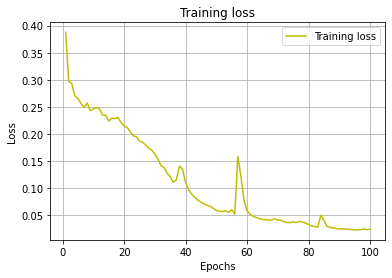

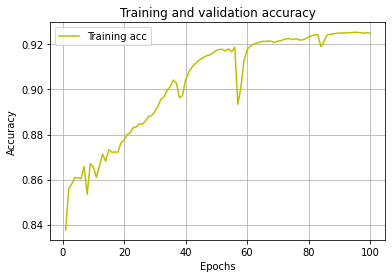

In [36]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load previously saved model

In [37]:
#Load previously saved model
from keras.models import load_model

model_path = '/content/drive/MyDrive/models/mapAI_small_100-epochs.hdf5'

model = load_model(model_path, compile=False)

### Prediction

In [38]:
# IOU threshold
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

4/4 [==============================] - 45s 1s/step


In [39]:
from keras.metrics import MeanIoU

# binary classification --> 2 classes
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7232361


(1, 480, 480, 1)
1/1 [==============================] - 0s 52ms/step
(480, 480)


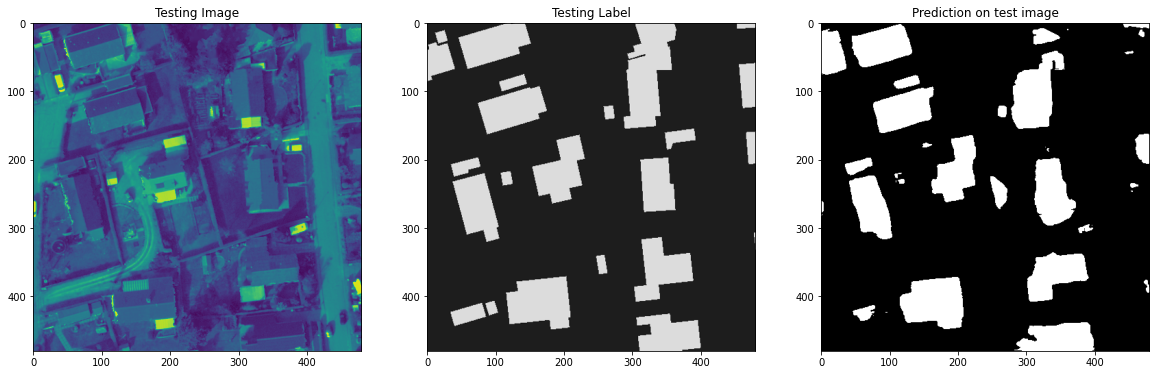

In [51]:
threshold = 0.5

import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(20, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

#### Problems




*   Test images and labels are different? Why?
*   Possible issue at dataset split?
*   Check if the mapAI_small dataset was correctly copied.

## To solve:
*   Plot real color images not gray
*   other?

Why: https://www.youtube.com/watch?v=coY2IA-oBvw



